In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import random as rdm
import os
np.random.seed(0)
import seaborn as sns
from scipy.optimize import linprog

In [2]:
#problem(1)
Rfunc1 = np.zeros((10,10))
Rfunc1[-1][-1] = 1.0
Rfunc2 = np.zeros((10, 10))
Rfunc2[1:7,4] = -100.0
Rfunc2[1,5] = -100.0
Rfunc2[1:4,6] = Rfunc2[7:9,6] = -100.0
Rfunc2[3,7] = Rfunc2[7,7] = -100.0
Rfunc2[3:8,8] = -100.0
Rfunc2[-1][-1] = 10.0

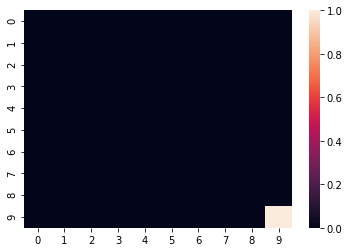

In [3]:
hm1 = sns.heatmap(Rfunc1)

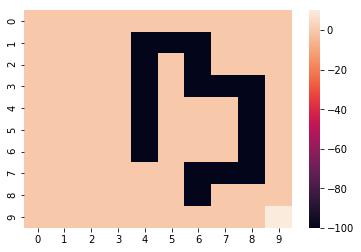

In [4]:
hm2 = sns.heatmap(Rfunc2)

In [5]:
#problem2
width = 10
height = 10
tp = np.zeros((height * width, 5, 4)) # third dimension is direction, last denotes action
#direction to next state 0 : up 1 : right 2 : down 3 : left 4: stay
#action 0 : up 1 : right 2 : down 3 : left
w = 0.1
dx = [0, 1, 0, -1, 0]
dy = [-1, 0, 1, 0, 0]

In [6]:
def isCorner(x, y, height, width):
    return (((y == height - 1) or (y == 0)) and ((x == width - 1) or (x == 0)))
def isEdge(x, y, height, width):
    return (x == 0) or (x == height - 1) or (y == 0) or(y == width - 1)
def offGrid(x, y, height, width):
    return (x < 0) or (x >= height) or (y < 0) or(y >= width)

In [7]:
def cornerSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): #action
        if(offGrid(x + dx[i], y + dy[i], height, width)):
            for j in range(4):
                if not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = 1 - w / 2.0
        else:
            for j in range(4):
                if i == j:
                    tp[state][j][i] = 1 - w + w / 4.0
                elif not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = w / 2.0
            
def edgeSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): #action
        if(offGrid(x + dx[i], y + dy[i], height, width)):
            for j in range(4):
                if not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = 1 - w + w / 4.0
        else:
            for j in range(4):
                if i == j:
                    tp[state][j][i] = 1 - w + w / 4.0
                elif not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = w / 4.0   
            
def innerSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): # atcion
        for j in range(4):
            if i == j:
                tp[state][j][i] = 1 - w + w / 4.0
            else:
                tp[state][j][i] = w / 4.0

In [8]:
w = 0.1
for i in range(height * width): #calculate transition prob
    x = i // height
    y = i % height
    if isCorner(x, y, height, width):
        cornerSol(x, y, tp, height, width, w)
    elif isEdge(x, y, height, width):
        edgeSol(x, y, tp, height, width, w)
    else:
        innerSol(x, y, tp, height, width, w)

In [9]:
def calStateValue(state, tp, Rfunc, Vs, discount):
    value = np.zeros(4)
    x = state // height
    y = state % height
    for action in range(4):
        for i in range(5):
            x1 = x + dx[i]
            y1 = y + dy[i]
            if offGrid(x1, y1, height, width):
                continue
            state1 = x1 * height + y1
            value[action] += tp[state][i][action] * (Rfunc[y1][x1] + discount * Vs[state1])
    return value
def calVs(Vs, tp, Rfunc, discount, theta):
    while True:
        delta = 0.0
        for s in range(width * height):
            actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
            maxActionValue = max(actionValue)
            delta = max(np.abs(maxActionValue - Vs[s]), delta)
            Vs[s] = maxActionValue
        if delta < theta:
            break

In [10]:
Vs1 = np.zeros(height * width)
discount = 0.8
theta = 0.01
calVs(Vs1, tp, Rfunc1, discount, theta)#calculate state value for each state

In [11]:
from tabulate import tabulate

In [12]:
Vs1_2d = Vs1.reshape((height, width))
print(tabulate(Vs1_2d.T,  tablefmt='fancy_grid'))

╒═══════════╤═══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│ 0.0417957 │ 0.0628379 │ 0.089742 │ 0.123849 │ 0.167081 │ 0.221883 │ 0.291354 │ 0.37942  │ 0.490983 │ 0.609648 │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 0.0628379 │ 0.0878701 │ 0.121557 │ 0.164514 │ 0.219246 │ 0.28899  │ 0.377871 │ 0.491061 │ 0.633219 │ 0.787354 │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 0.089742  │ 0.121557  │ 0.16439  │ 0.219132 │ 0.288903 │ 0.377826 │ 0.491156 │ 0.63549  │ 0.817355 │ 1.0186   │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 0.123849  │ 0.164514  │ 0.219132 │ 0.2889   │ 0.377825 │ 0.491159 │ 0.635601 │ 0.81961  │ 1.05219  │ 1.31506  │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼────────

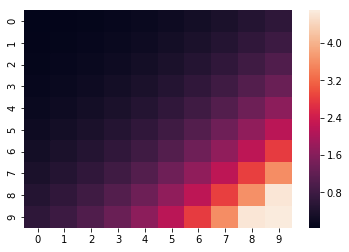

In [13]:
#problem3
hm3 = sns.heatmap(Vs1_2d.T)

In [14]:
#problem5
arrows = ['↑','→','↓','←']
def calOptimalAction(optimalAction, tp, Rfunc, Vs, discount):
    for s in range(height * width):
        actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
        optimal = np.argmax(actionValue)
        optimalAction[s] = optimal
def action2Arrow(action, arrows):
    return [arrows[int(i)] for i in action]

In [15]:
optimalAction1 = np.zeros(height * width)
calOptimalAction(optimalAction1, tp, Rfunc1, Vs1, discount)

In [16]:
optimalAction1_2d = optimalAction1.reshape((height, width))
arrows1 = action2Arrow(optimalAction1, arrows)
path1 = np.array(arrows1).reshape((height,width)).T
print(tabulate(optimalAction1_2d.T,  tablefmt='fancy_grid'))

╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛


In [17]:
print(tabulate(path1))

-  -  -  -  -  -  -  -  -  -
↓  →  →  →  →  →  →  ↓  ↓  ↓
↓  →  →  →  →  →  ↓  ↓  ↓  ↓
↓  ↓  →  →  →  ↓  ↓  ↓  ↓  ↓
↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓
↓  ↓  ↓  →  ↓  ↓  ↓  ↓  ↓  ↓
↓  ↓  →  →  →  →  ↓  ↓  ↓  ↓
↓  →  →  →  →  →  →  ↓  ↓  ↓
→  →  →  →  →  →  →  →  ↓  ↓
→  →  →  →  →  →  →  →  →  ↓
→  →  →  →  →  →  →  →  →  →
-  -  -  -  -  -  -  -  -  -


In [154]:
#problem6
Vs2 = np.zeros(height * width)
# print(tp.shape)
# print(Rfunc2.shape)
calVs(Vs2, tp, Rfunc2, discount, theta)#calculate state value for each state

In [88]:
Vs2_2d = Vs2.reshape((height, width))
print(tabulate(Vs2_2d.T,  tablefmt='fancy_grid'))

╒══════════╤══════════╤══════════╤════════════╤══════════╤════════════╤═══════════╤══════════╤═══════════╤══════════╕
│ 0.648477 │ 0.794107 │ 0.825238 │  0.536246  │ -2.37043 │  -4.23382  │ -1.92053  │  1.13111 │  1.59436  │  2.03821 │
├──────────┼──────────┼──────────┼────────────┼──────────┼────────────┼───────────┼──────────┼───────────┼──────────┤
│ 0.829852 │ 1.02124  │ 1.06603  │ -1.8679    │ -6.73822 │  -8.67375  │ -6.36979  │ -1.2948  │  1.92834  │  2.61047 │
├──────────┼──────────┼──────────┼────────────┼──────────┼────────────┼───────────┼──────────┼───────────┼──────────┤
│ 1.06361  │ 1.31651  │ 1.45008  │ -1.62403   │ -6.74151 │ -13.9112   │ -9.64923  │ -5.51104 │ -0.131013 │  3.35906 │
├──────────┼──────────┼──────────┼────────────┼──────────┼────────────┼───────────┼──────────┼───────────┼──────────┤
│ 1.36025  │ 1.6927   │ 1.94802  │ -1.23217   │ -6.32308 │  -7.97761  │ -7.93668  │ -9.42387 │ -1.91443  │  4.39063 │
├──────────┼──────────┼──────────┼────────────┼─────────

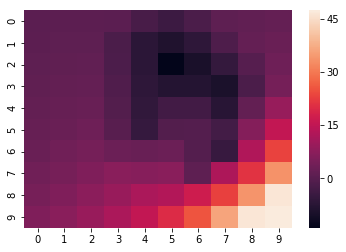

In [89]:
#problem7
hm4 = sns.heatmap(Vs2_2d.T)

In [90]:
#problem9
optimalAction2 = np.zeros(height * width)
calOptimalAction(optimalAction2, tp, Rfunc2, Vs2, discount)

In [91]:
optimalAction2_2d = optimalAction2.reshape((height, width))
arrows2 = action2Arrow(optimalAction2, arrows)
path2 = np.array(arrows2).reshape((height,width)).T
print(tabulate(optimalAction2_2d.T,  tablefmt='fancy_grid'))

╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ 2 │ 2 │ 2 │ 3 │ 3 │ 1 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 0 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 2 │ 0 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 2 │ 2 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 2 │ 3 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 3 │ 3 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 3 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛


In [96]:
print(tabulate(path2))

-  -  -  -  -  -  -  -  -  -
↓  ↓  ↓  ←  ←  →  →  →  →  ↓
↓  ↓  ↓  ←  ←  ↑  →  →  →  ↓
↓  ↓  ↓  ←  ←  ↓  →  →  →  ↓
↓  ↓  ↓  ←  ←  ↓  ↓  ↑  →  ↓
↓  ↓  ↓  ←  ←  ↓  ↓  ↓  →  ↓
↓  ↓  ↓  ←  ←  ↓  ↓  ←  →  ↓
↓  ↓  ↓  ↓  ↓  ↓  ←  ←  →  ↓
↓  ↓  ↓  ↓  ↓  ↓  ←  ↓  ↓  ↓
→  →  →  ↓  ↓  ↓  ↓  ↓  ↓  ↓
→  →  →  →  →  →  →  →  →  →
-  -  -  -  -  -  -  -  -  -


# IRL #

In [18]:
def tp2tpm(height, width, tp):
    tpm = np.zeros((height * width, 4, height * width))
    for s in range(tp.shape[0]):
        x = s // height
        y = s % height
        for action in range(tp.shape[2]):
            for i in range(tp.shape[1]):
                x1 = x + dx[i]
                y1 = y + dy[i]
                if not offGrid(x1, y1, height, width):
                    s1 = x1 * height + y1
                    tpm[s][action][s1] = tp[s][i][action]
    return tpm

In [97]:
def calculate_LP_D(a, s, policy, gamma, tp):
    # (Pa1 −Pa)(I−γPa1)−1
    return np.dot(tp[int(policy[s]), s] - tp[a, s], np.linalg.inv(np.eye(100) - gamma*tp[int(policy[s])]))

In [142]:
def calculate_accuracy(n_states, ground_truth, extracted_reward):
    extracted_reward = extracted_reward.reshape((height,width))
    Vs = np.zeros(height * width)
    discount = 0.8
    theta = 0.01
    calVs(Vs, tp, extracted_reward, discount, theta)
    optimalAction = np.zeros(height * width)
    calOptimalAction(optimalAction, tp, extracted_reward, Vs, discount)
#     print(tp.shape)
    count = 0
    for i in range(n_states):
        if ground_truth[i] == optimalAction[i]:
            count += 1
    return float(count)/float(n_states)

In [143]:
#Question 11:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import solvers,matrix
lamda_list = np.linspace(0,5,100)
# lamda_list = np.linspace(1,5,100)
A = {0,1,2,3}
n_actions = 4
n_states = 100
gamma = 0.8
tpm = tp2tpm(height, width, tp)
# print(tpm.shape)
transition_probability = np.transpose(tpm, (1, 0, 2))
# print(transition_probability)
Rmax1 = 0.0
for i in range(0,10):
    for j in range(0,10):
        Rmax1 = max(Rmax1, abs(Rfunc1[i,j]))    

In [144]:
def perform_IRL(optimalAction, transition_probability, Rmax, lamda_list):
    accuracy = []
    for lamda in lamda_list:
        n_states = 100
        policy = optimalAction
        C = -np.hstack([np.zeros(100), np.ones(100), -lamda*np.ones(100), np.zeros(100)]) 
#         print(C.shape)   
#         print(A - {policy[1]})
        T_stack = np.vstack([
                calculate_LP_D(a, s, policy, gamma, transition_probability)
                for s in range(n_states)
                for a in A - {policy[s]}
            ])
        one_stack = np.vstack([
                np.eye(1, n_states, s)
                for s in range(n_states)
                for a in A - {policy[s]}
            ])
        # X = [R, T, U, M]
        # (Pa1 −Pa)(I−γPa1)−1 * R >= T => -(Pa1 −Pa)(I−γPa1)−1 * R <= -T => -(Pa1 −Pa)(I−γPa1)−1 * R + T <= 0
        D_0 = np.hstack([-T_stack, one_stack,np.zeros((300,100)),np.zeros((300,100))])
        # (Pa1 −Pa)(I−γPa1)−1 * R >= 0 => -(Pa1 −Pa)(I−γPa1)−1 * R <= 0
        D_1 = np.hstack([-T_stack, np.zeros((300,100)),np.zeros((300,100)),np.zeros((300,100))])
        # R <= u and R >= -u => R-u<=0 and -R-u <=0
        D_2 = np.hstack([np.eye(n_states),np.zeros((100,100)),-np.eye(n_states),np.zeros((100,100))])
        D_3 = np.hstack([-np.eye(n_states),np.zeros((100,100)),-np.eye(n_states),np.zeros((100,100))])
        # R <= Rmax and R >= -Rmax => R - Rmax <=0 and -R - Rmax <=0
        D_4 = np.hstack([np.eye(n_states), np.zeros((100,100)), np.zeros((100,100)), -np.eye(n_states)])
        D_5 = np.hstack([-np.eye(n_states), np.zeros((100,100)), np.zeros((100,100)), -np.eye(n_states)])

        D = np.vstack([D_0, D_1, D_2, D_3, D_4, D_5])
        d = matrix(D)
        B = np.zeros((1000,1))
        b = matrix(B)
        c = matrix(C)
        results = solvers.lp(c, d, b)
        r = np.asarray(results["x"][:n_states], dtype=np.double)
        # print(r)
        res = r.reshape((n_states,))
#         print(res)
        temp_acc = calculate_accuracy(100, optimalAction, res)
        accuracy.append(temp_acc)
    return {'accuracy':accuracy, 'reward': res}

In [145]:
# extracted_reward1 = np.zeros((100,1))
res = perform_IRL(optimalAction1, transition_probability, Rmax1, lamda_list)
accuracy1 = res['accuracy']

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.5706e+00 -0.0000e+00  7e+02  1e+01  7e+00  3e+00
 2: -7.5495e+00 -0.0000e+00  2e+03  1e+01  6e+00  8e+00
 3: -6.6356e+01 -0.0000e+00  2e+04  1e+01  7e+00  7e+01
 4: -1.2930e+03 -0.0000e+00  5e+05  1e+01  7e+00  1e+03
 5: -1.2779e+05 -0.0000e+00  5e+07  1e+01  7e+00  1e+05
 6: -1.2779e+07 -0.0000e+00  5e+09  1e+01  7e+00  1e+07
 7: -1.2779e+09 -0.0000e+00  5e+11  1e+01  7e+00  1e+09
Certificate of dual infeasibility found.
(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.7316e+00 -0.0000e+00  6e+02  1e+01  7e+00  3e+00
 2: -5.9919e+00 -0.0000e+00  1e+03  1e+01  5e+00  6e+00
 3: -4.5681e+01 -0.0000e+00  1e+04  1e+01  5e+00  5e+01
 4: -8.6905e+02 -0.0000e+00  2e+05  1e+01  6e+00  9e+02
 5: -8.4893e+04 -0.0000e+00  2e+07  1e+01  6e+00  8e+04
 6: -8.4894e+06 -0.0000e+00  2e+09  1e+01  6e+00  8e+06

(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.5818e+00 -0.0000e+00  3e+02  1e+01  4e+00  3e+00
 2: -1.6015e+00 -0.0000e+00  8e+01  4e+00  2e+00  2e+00
 3: -4.8667e-01 -0.0000e+00  3e+01  1e+00  6e-01  5e-01
 4: -2.3308e-01 -0.0000e+00  1e+01  5e-01  2e-01  2e-01
 5: -4.7134e-01 -0.0000e+00  3e+01  5e-01  2e-01  5e-01
 6: -3.1471e+00 -0.0000e+00  2e+02  4e-01  2e-01  3e+00
 7: -2.5720e+02 -0.0000e+00  2e+04  4e-01  2e-01  3e+02
 8: -2.5714e+04 -0.0000e+00  2e+06  4e-01  2e-01  3e+04
 9: -2.5714e+06 -0.0000e+00  2e+08  4e-01  2e-01  3e+06
10: -2.5714e+08 -0.0000e+00  2e+10  4e-01  2e-01  3e+08
Certificate of dual infeasibility found.
(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.4646e+00 -0.0000e+00  3e+02  1e+01  4e+00  3e+00
 2: -1.4661e+00 -0.0000e+00  7e+01  4e+00  1e+00  2e+00
 3: -4.2375e-01 -0.0000e+00  3e+01  1e+00  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -1.4117e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -7.0336e-01 -0.0000e+00  6e+01  3e+00  9e-01  8e-01
 3: -1.8244e-01 -0.0000e+00  1e+01  9e-01  3e-01  2e-01
 4: -1.3932e-02 -0.0000e+00  1e+00  1e-01  3e-02  2e-02
 5: -1.1903e-04 -0.0000e+00  2e-02  2e-03  5e-04  2e-04
 6: -1.1898e-06 -0.0000e+00  2e-04  2e-05  5e-06  2e-06
 7: -1.1898e-08 -0.0000e+00  2e-06  2e-07  5e-08  2e-08
 8: -1.1898e-10 -0.0000e+00  2e-08  2e-09  5e-10  2e-10
Optimal solution found.
(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -1.3508e+00 -0.0000e+00  3e+02  9e+00  3e+00  2e+00
 2: -6.5830e-01 -0.0000e+00  5e+01  3e+00  8e-01  8e-01
 3: -1.6792e-01 -0.0000e+00  1e+01  8e-01  2e-01  2e-01
 4: -8.3763e-03 -0.0000e+00  1e+00  8e-02  2e-02  1e-02
 5: -7.7902e-05 -0.0000e+00  1e-02  9e-04  3e-04  1e-04
 6: -7.7882e-07 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -7.9168e-01 -0.0000e+00  3e+02  9e+00  2e+00  1e+00
 2: -2.5955e-01 -0.0000e+00  3e+01  2e+00  3e-01  3e-01
 3: -1.2999e-02 -0.0000e+00  2e+00  1e-01  3e-02  2e-02
 4: -1.3502e-04 -0.0000e+00  2e-02  2e-03  3e-04  2e-04
 5: -1.3499e-06 -0.0000e+00  2e-04  2e-05  3e-06  2e-06
 6: -1.3499e-08 -0.0000e+00  2e-06  2e-07  3e-08  2e-08
 7: -1.3499e-10 -0.0000e+00  2e-08  2e-09  3e-10  2e-10
Optimal solution found.
(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -7.6568e-01 -0.0000e+00  3e+02  8e+00  2e+00  1e+00
 2: -2.4723e-01 -0.0000e+00  3e+01  2e+00  3e-01  3e-01
 3: -1.0203e-02 -0.0000e+00  2e+00  1e-01  3e-02  1e-02
 4: -1.0567e-04 -0.0000e+00  2e-02  1e-03  3e-04  1e-04
 5: -1.0565e-06 -0.0000e+00  2e-04  1e-05  3e-06  1e-06
 6: -1.0565e-08 -0.0000e+00  2e-06  1e-07  3e-08  1e-08
 7: -1.0565e-10 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -4.9022e-01 -0.0000e+00  2e+02  7e+00  1e+00  7e-01
 2: -1.3101e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -2.5709e-03 -0.0000e+00  1e+00  7e-02  1e-02  5e-03
 4: -2.6097e-05 -0.0000e+00  1e-02  7e-04  1e-04  5e-05
 5: -2.6095e-07 -0.0000e+00  1e-04  7e-06  1e-06  5e-07
 6: -2.6095e-09 -0.0000e+00  1e-06  7e-08  1e-08  5e-09
 7: -2.6095e-11 -0.0000e+00  1e-08  7e-10  1e-10  5e-11
Optimal solution found.
(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -4.7729e-01 -0.0000e+00  2e+02  7e+00  1e+00  7e-01
 2: -1.2684e-01 -0.0000e+00  3e+01  1e+00  2e-01  2e-01
 3: -2.5362e-03 -0.0000e+00  1e+00  6e-02  1e-02  5e-03
 4: -2.5688e-05 -0.0000e+00  1e-02  7e-04  1e-04  5e-05
 5: -2.5686e-07 -0.0000e+00  1e-04  7e-06  1e-06  5e-07
 6: -2.5686e-09 -0.0000e+00  1e-06  7e-08  1e-08  5e-09
 7: -2.5686e-11 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.4797e-01 -0.0000e+00  2e+02  6e+00  8e-01  6e-01
 2: -8.3902e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.5190e-03 -0.0000e+00  7e-01  3e-02  4e-03  2e-03
 4: -1.5176e-05 -0.0000e+00  7e-03  3e-04  4e-05  2e-05
 5: -1.5176e-07 -0.0000e+00  7e-05  3e-06  4e-07  2e-07
 6: -1.5176e-09 -0.0000e+00  7e-07  3e-08  4e-09  2e-09
 7: -1.5176e-11 -0.0000e+00  7e-09  3e-10  4e-11  2e-11
Optimal solution found.
(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -3.4225e-01 -0.0000e+00  2e+02  6e+00  8e-01  5e-01
 2: -8.2367e-02 -0.0000e+00  2e+01  1e+00  1e-01  1e-01
 3: -1.4656e-03 -0.0000e+00  7e-01  3e-02  4e-03  2e-03
 4: -1.4643e-05 -0.0000e+00  7e-03  3e-04  4e-05  2e-05
 5: -1.4642e-07 -0.0000e+00  7e-05  3e-06  4e-07  2e-07
 6: -1.4642e-09 -0.0000e+00  7e-07  3e-08  4e-09  2e-09
 7: -1.4642e-11 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.7193e-01 -0.0000e+00  2e+02  6e+00  6e-01  5e-01
 2: -6.2936e-02 -0.0000e+00  2e+01  9e-01  9e-02  9e-02
 3: -8.9747e-04 -0.0000e+00  5e-01  2e-02  2e-03  1e-03
 4: -8.9655e-06 -0.0000e+00  5e-03  2e-04  2e-05  1e-05
 5: -8.9653e-08 -0.0000e+00  5e-05  2e-06  2e-07  1e-07
 6: -8.9653e-10 -0.0000e+00  5e-07  2e-08  2e-09  1e-09
 7: -8.9653e-12 -0.0000e+00  5e-09  2e-10  2e-11  1e-11
Optimal solution found.
(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  3e+00  1e+00
 1: -2.6789e-01 -0.0000e+00  2e+02  6e+00  6e-01  5e-01
 2: -6.1641e-02 -0.0000e+00  2e+01  9e-01  9e-02  9e-02
 3: -8.6792e-04 -0.0000e+00  5e-01  2e-02  2e-03  1e-03
 4: -8.6703e-06 -0.0000e+00  5e-03  2e-04  2e-05  1e-05
 5: -8.6702e-08 -0.0000e+00  5e-05  2e-06  2e-07  1e-07
 6: -8.6702e-10 -0.0000e+00  5e-07  2e-08  2e-09  1e-09
 7: -8.6702e-12 

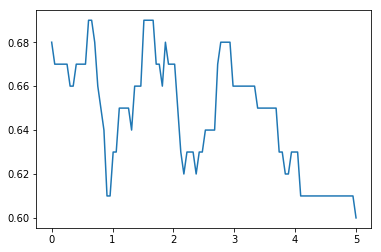

In [133]:
# plot 
plt.plot(lamda_list, accuracy1)
plt.show()

### Q12 find lamda max###

In [135]:
max_accuracy1 = max(accuracy1)
maxLamda = lamda_list[accuracy1.index(max_accuracy1)]
print(maxLamda, max_accuracy1)

0.6060606060606061 0.69


### Q13 generate heat maps of the ground truth and extracted reward###

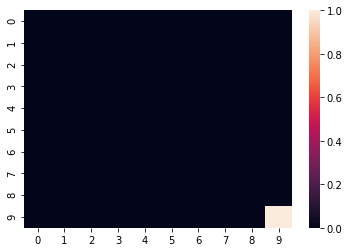

In [136]:
hm_rfunc1 = sns.heatmap(Rfunc1)

In [148]:
# extracted_reward_max_lamda1 = np.zeros((100,1))
res = perform_IRL(optimalAction1, transition_probability, Rmax1, [maxLamda])
extracted_reward_max_lamda1 = res['reward'].reshape((height,width))

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -2.8961e+00 -0.0000e+00  3e+02  1e+01  4e+00  3e+00
 2: -2.0324e+00 -0.0000e+00  1e+02  5e+00  2e+00  2e+00
 3: -1.0465e+00 -0.0000e+00  6e+01  2e+00  8e-01  1e+00
 4: -2.0036e+00 -0.0000e+00  1e+02  1e+00  5e-01  2e+00
 5: -2.3294e+01 -0.0000e+00  1e+03  1e+00  5e-01  2e+01
 6: -2.0986e+03 -0.0000e+00  1e+05  1e+00  5e-01  2e+03
 7: -2.0984e+05 -0.0000e+00  1e+07  1e+00  5e-01  2e+05
 8: -2.0984e+07 -0.0000e+00  1e+09  1e+00  5e-01  2e+07
Certificate of dual infeasibility found.
(100, 5, 4)


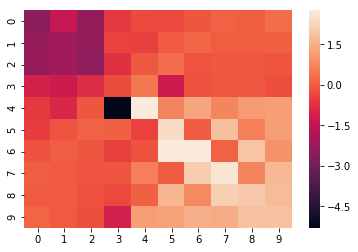

In [149]:
# print(extracted_reward_max_lamda1.reshape((height, width)))
hm_er1 = sns.heatmap(extracted_reward_max_lamda1)

### Q14 compute the optimal values of the states with extracted reward and generate heatmap ###

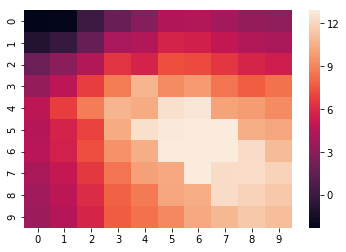

In [156]:
Vs_max_lamda1 = np.zeros(height * width)
calVs(Vs_max_lamda1, tp, extracted_reward_max_lamda1, discount, theta)
Vs_max_lamda1_2d = Vs_max_lamda1.reshape((height, width))
hm_vs = sns.heatmap(Vs_max_lamda1_2d)

### Q16 Use the extracted reward function found in question 13 to compute the optimal policy of the agent. ###

In [157]:
optimalAction_max_lamda1 = np.zeros(height * width)
calOptimalAction(optimalAction_max_lamda1, tp,extracted_reward_max_lamda1 , Vs_max_lamda1, discount)
optimalAction_max_lamda1_2d = optimalAction_max_lamda1.reshape((height, width))
arrows_max_lamda1 = action2Arrow(optimalAction_max_lamda1, arrows)
path_max_lamda1 = np.array(arrows_max_lamda1).reshape((height,width)).T
print(tabulate(optimalAction_max_lamda1_2d.T,  tablefmt='fancy_grid'))
print(tabulate(path_max_lamda1))

╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 2 │ 1 │ 1 │ 2 │ 3 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 3 │ 3 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 0 │ 0 │ 3 │ 3 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 0 │ 0 │ 3 │ 3 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 0 │ 0 │ 3 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛
-  -  -  -  -  -  -  -  -  -
→  →  →  →  ↓  ↓  ↓  ↓  ↓  ↓
↓  →  →  →  ↓  ↓  ↓  ↓  ↓  ↓
↓  ↓  →  →  ↓  ↓  ↓  ↓  ↓  ↓
→ 

### Q18 ###

In [158]:
Rmax2 = 0
for i in range(0,10):
    for j in range(0,10):
        Rmax2 = max(Rmax2, abs(Rfunc2[i,j]))    
# Rmax = Rfunc2.max()
print(Rmax2)


100.0


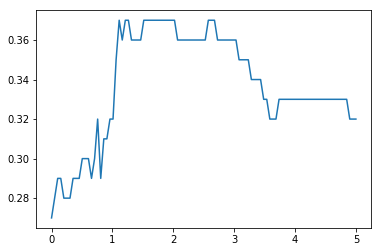

In [160]:
# Q18
plt.plot(lamda_list, accuracy2)
plt.show()

In [159]:
# Q19
res = perform_IRL(optimalAction2, transition_probability, Rmax2, lamda_list)
accuracy2 = res['accuracy']


     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.5466e+00 -0.0000e+00  7e+02  1e+01  9e+00  3e+00
 2: -5.5235e+00 -0.0000e+00  2e+03  1e+01  8e+00  6e+00
 3: -2.0158e+01 -0.0000e+00  8e+03  1e+01  9e+00  2e+01
 4: -1.3025e+02 -0.0000e+00  5e+04  1e+01  9e+00  1e+02
 5: -1.2123e+04 -0.0000e+00  5e+06  1e+01  9e+00  1e+04
 6: -1.2122e+06 -0.0000e+00  5e+08  1e+01  9e+00  1e+06
 7: -1.2122e+08 -0.0000e+00  5e+10  1e+01  9e+00  1e+08
 8: -1.2122e+10 -0.0000e+00  5e+12  1e+01  9e+00  1e+10
Certificate of dual infeasibility found.
(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  2e+01  1e+00
 1: -2.6737e+00 -0.0000e+00  6e+02  1e+01  8e+00  3e+00
 2: -4.7057e+00 -0.0000e+00  1e+03  1e+01  8e+00  5e+00
 3: -1.5493e+01 -0.0000e+00  5e+03  1e+01  7e+00  2e+01
 4: -7.4475e+01 -0.0000e+00  2e+04  1e+01  7e+00  7e+01
 5: -6.1224e+03 -0.0000e+00  2e+06  1e+01  7e+00  6e+03

(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.7233e+00 -0.0000e+00  4e+02  1e+01  6e+00  3e+00
 2: -2.2609e+00 -0.0000e+00  2e+02  5e+00  3e+00  2e+00
 3: -1.6494e+00 -0.0000e+00  1e+02  3e+00  2e+00  2e+00
 4: -1.9647e+00 -0.0000e+00  2e+02  3e+00  2e+00  2e+00
 5: -3.7916e+00 -0.0000e+00  5e+02  3e+00  1e+00  4e+00
 6: -4.6879e+01 -0.0000e+00  5e+03  2e+00  1e+00  5e+01
 7: -4.4740e+03 -0.0000e+00  5e+05  2e+00  1e+00  4e+03
 8: -4.4738e+05 -0.0000e+00  5e+07  2e+00  1e+00  4e+05
 9: -4.4738e+07 -0.0000e+00  5e+09  2e+00  1e+00  4e+07
Certificate of dual infeasibility found.
(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  2e+01  1e+00
 1: -2.6098e+00 -0.0000e+00  4e+02  1e+01  6e+00  3e+00
 2: -2.1095e+00 -0.0000e+00  1e+02  5e+00  3e+00  2e+00
 3: -1.4159e+00 -0.0000e+00  1e+02  3e+00  2e+00  2e+00
 4: -1.5188e+00 -0.0000e+00  2e+02  2e+00  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.6643e+00 -0.0000e+00  3e+02  1e+01  4e+00  2e+00
 2: -1.0792e+00 -0.0000e+00  1e+02  5e+00  2e+00  1e+00
 3: -5.8062e-01 -0.0000e+00  5e+01  3e+00  1e+00  7e-01
 4: -1.7267e-01 -0.0000e+00  1e+01  9e-01  4e-01  2e-01
 5: -2.1809e-02 -0.0000e+00  4e+00  3e-01  1e-01  3e-02
 6:  1.6512e-04 -0.0000e+00  4e-01  3e-02  1e-02  9e-04
 7:  1.1371e-05 -0.0000e+00  8e-03  8e-04  3e-04  1e-05
 8:  1.1367e-07 -0.0000e+00  8e-05  8e-06  3e-06  1e-07
 9:  1.1367e-09 -0.0000e+00  8e-07  8e-08  3e-08  1e-09
10:  1.1367e-11 -0.0000e+00  8e-09  8e-10  3e-10  1e-11
Optimal solution found.
(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.5876e+00 -0.0000e+00  3e+02  1e+01  4e+00  2e+00
 2: -1.0145e+00 -0.0000e+00  1e+02  4e+00  2e+00  1e+00
 3: -5.3022e-01 -0.0000e+00  5e+01  3e+00  1e+00  6e-01
 4: -1.4073e-01 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -9.6504e-01 -0.0000e+00  3e+02  1e+01  3e+00  1e+00
 2: -5.3099e-01 -0.0000e+00  9e+01  4e+00  1e+00  7e-01
 3: -1.8086e-01 -0.0000e+00  3e+01  2e+00  5e-01  2e-01
 4: -2.2877e-02 -0.0000e+00  4e+00  2e-01  8e-02  3e-02
 5: -1.8015e-04 -0.0000e+00  7e-02  5e-03  2e-03  4e-04
 6: -1.8007e-06 -0.0000e+00  7e-04  5e-05  2e-05  4e-06
 7: -1.8007e-08 -0.0000e+00  7e-06  5e-07  2e-07  4e-08
 8: -1.8007e-10 -0.0000e+00  7e-08  5e-09  2e-09  4e-10
Optimal solution found.
(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  9e+00  1e+00
 1: -9.3046e-01 -0.0000e+00  3e+02  1e+01  3e+00  1e+00
 2: -5.0749e-01 -0.0000e+00  9e+01  4e+00  1e+00  6e-01
 3: -1.6593e-01 -0.0000e+00  3e+01  2e+00  5e-01  2e-01
 4: -2.0771e-02 -0.0000e+00  3e+00  2e-01  7e-02  3e-02
 5: -1.7400e-04 -0.0000e+00  6e-02  4e-03  1e-03  3e-04
 6: -1.7389e-06 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -6.0964e-01 -0.0000e+00  3e+02  8e+00  2e+00  9e-01
 2: -3.0608e-01 -0.0000e+00  8e+01  3e+00  8e-01  4e-01
 3: -5.1004e-02 -0.0000e+00  2e+01  8e-01  2e-01  8e-02
 4: -2.0340e-03 -0.0000e+00  7e-01  4e-02  9e-03  3e-03
 5: -2.0437e-05 -0.0000e+00  7e-03  4e-04  9e-05  3e-05
 6: -2.0435e-07 -0.0000e+00  7e-05  4e-06  9e-07  3e-07
 7: -2.0435e-09 -0.0000e+00  7e-07  4e-08  9e-09  3e-09
 8: -2.0435e-11 -0.0000e+00  7e-09  4e-10  9e-11  3e-11
Optimal solution found.
(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  7e+00  1e+00
 1: -5.9210e-01 -0.0000e+00  3e+02  8e+00  2e+00  9e-01
 2: -2.9498e-01 -0.0000e+00  8e+01  3e+00  8e-01  4e-01
 3: -4.9670e-02 -0.0000e+00  2e+01  8e-01  2e-01  8e-02
 4: -1.9381e-03 -0.0000e+00  7e-01  4e-02  9e-03  3e-03
 5: -1.9452e-05 -0.0000e+00  7e-03  4e-04  9e-05  3e-05
 6: -1.9451e-07 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -4.1092e-01 -0.0000e+00  3e+02  8e+00  1e+00  6e-01
 2: -2.0682e-01 -0.0000e+00  8e+01  3e+00  5e-01  3e-01
 3: -2.0563e-02 -0.0000e+00  1e+01  5e-01  9e-02  4e-02
 4: -4.1250e-04 -0.0000e+00  2e-01  1e-02  2e-03  7e-04
 5: -4.1220e-06 -0.0000e+00  2e-03  1e-04  2e-05  7e-06
 6: -4.1220e-08 -0.0000e+00  2e-05  1e-06  2e-07  7e-08
 7: -4.1220e-10 -0.0000e+00  2e-07  1e-08  2e-09  7e-10
 8: -4.1220e-12 -0.0000e+00  2e-09  1e-10  2e-11  7e-12
Optimal solution found.
(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  6e+00  1e+00
 1: -3.9918e-01 -0.0000e+00  3e+02  8e+00  1e+00  6e-01
 2: -2.0277e-01 -0.0000e+00  8e+01  3e+00  5e-01  3e-01
 3: -1.9747e-02 -0.0000e+00  1e+01  5e-01  9e-02  4e-02
 4: -3.8306e-04 -0.0000e+00  2e-01  1e-02  2e-03  7e-04
 5: -3.8279e-06 -0.0000e+00  2e-03  1e-04  2e-05  7e-06
 6: -3.8278e-08 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -2.8831e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.6611e-01 -0.0000e+00  9e+01  3e+00  5e-01  3e-01
 3: -1.4729e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.3963e-04 -0.0000e+00  2e-01  6e-03  1e-03  4e-04
 5: -2.3951e-06 -0.0000e+00  2e-03  6e-05  1e-05  4e-06
 6: -2.3951e-08 -0.0000e+00  2e-05  6e-07  1e-07  4e-08
 7: -2.3951e-10 -0.0000e+00  2e-07  6e-09  1e-09  4e-10
 8: -2.3951e-12 -0.0000e+00  2e-09  6e-11  1e-11  4e-12
Optimal solution found.
(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  5e+00  1e+00
 1: -2.8279e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.6448e-01 -0.0000e+00  9e+01  3e+00  5e-01  3e-01
 3: -1.4744e-02 -0.0000e+00  1e+01  4e-01  7e-02  3e-02
 4: -2.3914e-04 -0.0000e+00  2e-01  6e-03  1e-03  4e-04
 5: -2.3902e-06 -0.0000e+00  2e-03  6e-05  1e-05  4e-06
 6: -2.3902e-08 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.2474e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.4952e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4546e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.1444e-04 -0.0000e+00  2e-01  6e-03  8e-04  4e-04
 5: -2.1435e-06 -0.0000e+00  2e-03  6e-05  8e-06  4e-06
 6: -2.1435e-08 -0.0000e+00  2e-05  6e-07  8e-08  4e-08
 7: -2.1435e-10 -0.0000e+00  2e-07  6e-09  8e-10  4e-10
 8: -2.1435e-12 -0.0000e+00  2e-09  6e-11  8e-12  4e-12
Optimal solution found.
(100, 5, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  4e+00  1e+00
 1: -2.2114e-01 -0.0000e+00  3e+02  8e+00  1e+00  5e-01
 2: -1.4878e-01 -0.0000e+00  1e+02  3e+00  4e-01  2e-01
 3: -1.4510e-02 -0.0000e+00  1e+01  4e-01  6e-02  3e-02
 4: -2.1205e-04 -0.0000e+00  2e-01  6e-03  8e-04  4e-04
 5: -2.1197e-06 -0.0000e+00  2e-03  6e-05  8e-06  4e-06
 6: -2.1196e-08 

In [161]:
# Q19
max_accuracy2 = max(accuracy2)
maxLamda2 = lamda_list[accuracy2.index(max_accuracy2)]
print(maxLamda2, max_accuracy2)

1.1111111111111112 0.37


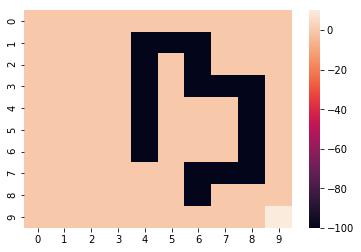

In [165]:
# Q20
hm_rfunc2 = sns.heatmap(Rfunc2)


     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  3e+01  1e+01  1e+00
 1: -1.8310e+00 -0.0000e+00  3e+02  1e+01  5e+00  2e+00
 2: -1.2240e+00 -0.0000e+00  1e+02  5e+00  2e+00  1e+00
 3: -6.9509e-01 -0.0000e+00  6e+01  3e+00  1e+00  8e-01
 4: -2.5310e-01 -0.0000e+00  2e+01  1e+00  5e-01  3e-01
 5: -3.8179e-02 -0.0000e+00  6e+00  3e-01  1e-01  5e-02
 6: -3.7493e-03 -0.0000e+00  1e+00  1e-01  4e-02  7e-03
 7:  3.2932e-04 -0.0000e+00  2e-01  2e-02  7e-03  2e-04
 8:  6.0593e-06 -0.0000e+00  3e-03  3e-04  1e-04  3e-06
 9:  6.0548e-08 -0.0000e+00  3e-05  3e-06  1e-06  3e-08
10:  6.0547e-10 -0.0000e+00  3e-07  3e-08  1e-08  3e-10
11:  6.0547e-12 -0.0000e+00  3e-09  3e-10  1e-10  3e-12
Optimal solution found.
(100, 5, 4)


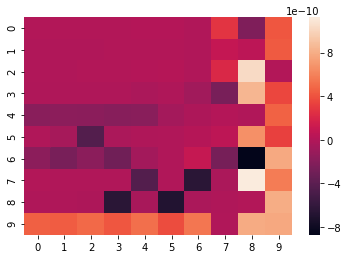

In [166]:
res = perform_IRL(optimalAction2, transition_probability, Rmax2, [maxLamda2])
extracted_reward_max_lamda2 = res['reward'].reshape((height,width))
hm_er1 = sns.heatmap(extracted_reward_max_lamda2)

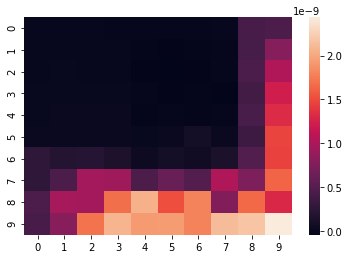

In [163]:
#Q21
Vs_max_lamda2 = np.zeros(height * width)
calVs(Vs_max_lamda2, tp, extracted_reward_max_lamda2, discount, theta)
Vs_max_lamda2_2d = Vs_max_lamda2.reshape((height, width))
hm_vs = sns.heatmap(Vs_max_lamda2_2d)

In [164]:
#Q23
optimalAction_max_lamda2 = np.zeros(height * width)
calOptimalAction(optimalAction_max_lamda2, tp,extracted_reward_max_lamda2 , Vs_max_lamda2, discount)
optimalAction_max_lamda2_2d = optimalAction_max_lamda2.reshape((height, width))
arrows_max_lamda2 = action2Arrow(optimalAction_max_lamda2, arrows)
path_max_lamda2 = np.array(arrows_max_lamda2).reshape((height,width)).T
print(tabulate(optimalAction_max_lamda2_2d.T,  tablefmt='fancy_grid'))
print(tabulate(path_max_lamda2))

╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 0 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 0 │ 1 │ 1 │ 1 │ 2 │ 1 │ 1 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ 0 │ 1 │ 1 │ 1 │ 1 │ 3 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 0 │ 0 │ 0 │ 0 │ 2 │ 1 │ 1 │ 0 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 3 │ 3 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 1 │ 1 │ 1 │ 2 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 2 │ 0 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 2 │ 1 │ 2 │ 1 │ 1 │ 1 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛
-  -  -  -  -  -  -  -  -  -
→  →  →  →  →  →  →  ↑  ↓  ↓
↑  →  →  →  ↓  →  →  ↓  ↓  ↓
→  →  →  →  →  →  →  →  ↓  ↓
↑ 